<a href="https://colab.research.google.com/github/vkth7/Going-Deeper-CV-/blob/main/GD1/%5BGD1%5DResNet%20Ablation%20Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0) 라이브러리 버전 확인하기
---
<br>

사용할 라이브러리 버전을 둘러봅시다.

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import cv2
import glob
import os
import urllib3
urllib3.disable_warnings()

#1) ResNet 기본 블록 구성하기
---
<br>

이제 실전으로 돌아와서 ResNet-34와 ResNet-50 네트워크를 직접 만든다고 생각해 봅시다. 우선 ResNet-34와 ResNet-50에서 사용되는 블록의 공통점을 찾고 차이점을 찾아봅시다.
<br><br>

- [Deep Residual Learning for Image Recognition(paper)](https://arxiv.org/pdf/1512.03385.pdf)
- [빛과 같은 카이밍허님의 깃헙](https://github.com/KaimingHe/deep-residual-networks)

<br>

![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-1-P-table1.max-800x600.png)

**Q1. ResNet논문에 소개된 위 표에서, ResNet 34와 50에서 사용된 블록들의 공통점과 차이점을 비교해보고 그 특징을 정리해봅시다.**

- ResNet-34와 ResNet-50은 모두 conv block이라고 불리는 블록 구조를 각각 3, 4, 6, 3개씩 반복해서 쌓은 형태라는 공통점을 가지고 있습니다. 그러나 ResNet-34와 ResNet-50의 블록 내부 구성은 약간 다릅니다. ResNet-34의 경우 Block은 3x3 kernel인 Convolution layer로만 구성되어있지만, ResNet-50은 1x1 Convolution이 앞뒤로 붙어 더 많은 레이어를 한 블록 내에 가지게 됩니다.

<br>

위의 퀴즈의 답을 어느 정도 스스로 찾아내셨다면 ResNet의 기본 블록, 또는 Residual 블록(residual block)이 어떻게 구성되어야 할지 감이 오셨을 것입니다. Learning by Doing 이라고 하죠! 이번에는 ResNet의 블록을 직접 만들어 봅시다! 혹시나 모델 내의 앞과 뒤에서 반복되지 않을 것 같은 부분은 함수로 구현하지 않아도 됩니다.
<br><br>
우리가 지금 만들어야 하는 것은 블록을 생성하는 함수입니다. 처음이라 너무 막연하실 수 있겠지만 여러분들은 이미 몇 번의 경험이 있습니다.
일단은 VGG에서도 블록을 생성하는 함수를 만들었습니다. ResNet이라 하더라도 아이디어의 기본 원리는 다르지 않습니다.
<br><br>
그리고, 여러분들은 아마 이전에 VGG-16이나 ResNet-50 모델을 만들어서 훈련까지 시켜본 경험들이 있으실 것입니다. 코드를 스스로 구현한 것이 아니라 공개된 오픈소스를 활용해서 빠르게 구성했겠지만, 블록 생성 함수가 어떤 형태로 만들어지는지를 이미 경험해 보신 바 있을 테니 그것을 참고하셔도 도움이 될 것입니다.
<br><br>
하지만 이번 단계에서는 가급적 ResNet 논문을 통해서 구현 방법에 대한 정보를 얻으시기를 권합니다. 논문만 보고 스스로 구현해 보는 경험을 통해 딥러닝 개발자로서의 내공과 자신감이 다져지게 될 것입니다.

#2) ResNet-34, ResNet-50 Complete Model
---
<br>

><br>
>
>ResNet 모델 구현 시 Sequential API나 Subclass API를 사용한다면, 그 과정에서 모델 단위로 기존의 코드를 재활용했을 때 model.summary() 호출 시 서브모델 내부의 레이어 구성이 생략되고 서브모델 단위로만 출력될 우려가 있습니다. 모델 구성만을 위해서는 그런 방법도 무방하지만, 가급적 이번 실습에서는 VGG 실습 예시에서처럼 Functional API 를 구성하는 방식을 사용할 것을 권합니다.
><br><br>

##ResNet-34

VGG와 같이 블록을 만드는 함수를 사용해서 직접 전체 모델을 만들어 봅시다. ResNet-34와 ResNet-50의 차이에 따라 달라지는 구성(configuration)을 함수에 전달해서 같은 생성 함수 build_resnet()를 통해서 ResNet의 여러 가지 버전들을 모두 만들어 낼 수 있도록 해야 합니다.

In [2]:
# function for building ResNet Block

def build_resnet_block(input_layer,
                       num_cnn=3, 
                       channel=64,
                       block_num=0,
                       is_50=False
                       ):
    # 입력 레이어
    x = input_layer

    input = input_layer

    if not is_50:
        # ResNet-34
        for cnn_num in range(num_cnn):
            if block_num == 0:
                x = layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'block{block_num}_conv{cnn_num}_1'
                    )(x)


            elif cnn_num == 0:
                input = layers.Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    strides=(2,2),
                    padding='same',
                    kernel_initializer='he_normal',
                    name=f'block{block_num}_conv{0}'
                    )(input)

                input = layers.BatchNormalization()(input)


                x = layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    strides=2,
                    padding='same',
                    kernel_initializer='he_normal',
                    name=f'block{block_num}_conv{cnn_num}_1'
                    )(x)

            else:
                x = layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'block{block_num}_conv{cnn_num}_1'
                    )(x)

            x = layers.BatchNormalization()(x)

            x = layers.Activation('relu')(x)

            x = layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}_2'
                )(x)

            x = layers.BatchNormalization()(x)

            if cnn_num==0:
                x = layers.Add()([input, x])

            else:
                x = layers.Add()([output, x])

            x = layers.Activation('relu')(x)

            output = x

    else:
        # ResNet-50
        for cnn_num in range(num_cnn):

            if block_num==0 and cnn_num==0:
                
                input = layers.Conv2D(
                    filters=4*channel,
                    kernel_size=(1,1),
                    kernel_initializer='he_normal',
                    name=f'block{block_num}_conv{0}'
                    )(input)

                input = layers.BatchNormalization()(input)

                x = layers.Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    kernel_initializer='he_normal',
                    name=f'block{block_num}_conv{cnn_num}_1'
                    )(x)

            elif cnn_num==0:

                input = layers.Conv2D(
                    filters=4*channel,
                    kernel_size=(1,1),
                    strides=(2,2),
                    kernel_initializer='he_normal',
                    name=f'block{block_num}_conv{0}'
                    )(input)

                input = layers.BatchNormalization()(input)

                x = layers.Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    strides=(2,2),
                    kernel_initializer='he_normal',
                    name=f'block{block_num}_conv{cnn_num}_1'
                    )(x)

            else:
                x = layers.Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    kernel_initializer='he_normal',
                    name=f'block{block_num}_conv{cnn_num}_1'
                    )(x)            

            x = layers.BatchNormalization()(x)

            x = layers.Activation('relu')(x)

            x = layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}_2'
                )(x)

            x = layers.BatchNormalization()(x)

            x = layers.Activation('relu')(x)

            x = layers.Conv2D(
                filters=4*channel,
                kernel_size=(1,1),
                kernel_initializer='he_normal',
                name=f'block{block_num}_conv{cnn_num}_3'
                )(x)
            
            x = layers.BatchNormalization()(x)

            if cnn_num==0:
                x = layers.Add()([input, x])

            else:
                x = layers.Add()([output, x])

            x = layers.Activation('relu')(x)

            output = x

    return output

In [3]:
def build_resnet(input_shape=(224,224,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=2,
                 is_50=False):

    # input layer
    input_layer = layers.Input(shape=input_shape)

    output = input_layer
    # Conv2D layer
    output = layers.Conv2D(filters=64,
                      kernel_size=(7,7),
                      strides=2,
                      kernel_initializer='he_normal',
                      padding='same',
                      )(output)

    output = layers.BatchNormalization()(output)

    output = layers.Activation('relu')(output)

    # Max Pooling layer
    output = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
    )(output)

    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):

        output = build_resnet_block(output,
                                    num_cnn=num_cnn, 
                                    channel=channel,
                                    block_num=i,
                                    is_50=is_50
                                    )
    
    output = layers.GlobalAveragePooling2D()(output)

    output = layers.Dense(num_classes,
                          activation='softmax',
                          name='predictions'
                          )(output)

    model = keras.Model(inputs=input_layer,
                        outputs=output
                        )
    return model

In [4]:
resnet_34 = build_resnet(input_shape=(32, 32, 3), is_50=False)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 16, 16, 64)   0           ['batch_normalization[0][0]']

##ResNet-50

위에서 만든 함수에 config를 조절해서 ResNet-50을 만들어 봅니다. 구조가 원하는 대로 만들어졌는지 확인하고 이상이 있다면 수정합니다.

In [5]:
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 64)   9472        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_36 (BatchN  (None, 16, 16, 64)  256         ['conv2d_1[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 activation_33 (Activation)     (None, 16, 16, 64)   0           ['batch_normalization_36[0]

ResNet-50은 구현마다 약간씩 다르게 나올 수 있습니다. 왜냐하면 Residual 블록의 Batch Normalization과 ReLU 레이어의 위치가 논문에 명시되지 않았기 때문이죠!
<br><br>
하지만 ResNet을 고안한 4인방은 이에 대해 또 한번 논문을 씁니다. Residual 블록에 대해서 자세하게 씁니다. 이 논문을 읽어보면 오리지널 ResNet-50에 대한 힌트가 약.간. 있을 수도 있습니다~!
<br><br>

- [Identity Mappings in Deep Residual Networks](https://arxiv.org/pdf/1603.05027.pdf)

#3) 일반 네트워크(plain network) 만들기
---
<br>

블록 코드 수정하기
<br><br>
우리는 앞에서 ResNet 모델을 구현했습니다. ResNet의 핵심 아이디어는 skip connection과 residual network기 때문에, ResNet의 효과를 보여주기 위해서는 skip connection이 없는 일반 네트워크(plain net)가 필요합니다. 위에서 ResNet 블록을 만들기 위한 함수를 그대로 활용해서 skip connection이 없는 블록을 만들 수 있도록 기능을 추가해 주세요!
<br><br><br>
전체 함수 코드 수정하기
<br><br>
이제 위에서 만든 블록 함수를 토대로 전체 네트워크를 만들 수 있도록 전체 네트워크 코드를 수정합시다. ResNet-50과 ResNet-34, 그리고 같은 레이어를 가지지만 skip connection이 없는 PlainNet-50과 PlainNet-34를 만들 수 있는 함수 ```build_plainnet()```를 만들어 보세요. 이때 입력 이미지의 크기는 ```(224, 224, 3)```으로 해주세요.

In [6]:
# function for building ResNet Block

def build_resnet_block(input_layer,
                       num_cnn=3, 
                       channel=64,
                       block_num=0,
                       is_50=False
                       ):
    # 입력 레이어
    x = input_layer

    if not is_50:
        # PlainNet-34
        for cnn_num in range(num_cnn):
            if block_num == 0:
                x = layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'block{block_num}_conv{cnn_num}_1'
                    )(x)


            elif cnn_num == 0:
                
                x = layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    strides=2,
                    padding='same',
                    kernel_initializer='he_normal',
                    name=f'block{block_num}_conv{cnn_num}_1'
                    )(x)

            else:
                x = layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'block{block_num}_conv{cnn_num}_1'
                    )(x)

            x = layers.BatchNormalization()(x)

            x = layers.Activation('relu')(x)

            x = layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}_2'
                )(x)

            x = layers.BatchNormalization()(x)

            x = layers.Activation('relu')(x)

            output = x

    else:
        # PlainNet-50
        for cnn_num in range(num_cnn):

            if block_num==0:
                
                x = layers.Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    kernel_initializer='he_normal',
                    name=f'block{block_num}_conv{cnn_num}_1'
                    )(x)

            elif cnn_num==0:

                x = layers.Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    strides=(2,2),
                    kernel_initializer='he_normal',
                    name=f'block{block_num}_conv{cnn_num}_1'
                    )(x)

            else:
                x = layers.Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    kernel_initializer='he_normal',
                    name=f'block{block_num}_conv{cnn_num}_1'
                    )(x)            

            x = layers.BatchNormalization()(x)

            x = layers.Activation('relu')(x)

            x = layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}_2'
                )(x)

            x = layers.BatchNormalization()(x)

            x = layers.Activation('relu')(x)

            x = layers.Conv2D(
                filters=4*channel,
                kernel_size=(1,1),
                kernel_initializer='he_normal',
                name=f'block{block_num}_conv{cnn_num}_3'
                )(x)
            
            x = layers.BatchNormalization()(x)

            x = layers.Activation('relu')(x)

            output = x

    return output

In [7]:
def build_plainnet(input_shape=(224,224,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=10,
                 is_50=False):

    # input layer
    input_layer = layers.Input(shape=input_shape)

    output = input_layer
    # Conv2D layer
    output = layers.Conv2D(filters=64,
                      kernel_size=(7,7),
                      strides=2,
                      kernel_initializer='he_normal',
                      padding='same',
                      )(output)

    output = layers.BatchNormalization()(output)

    output = layers.Activation('relu')(output)

    # Max Pooling layer
    output = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
    )(output)

    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):

        output = build_resnet_block(output,
                                    num_cnn=num_cnn, 
                                    channel=channel,
                                    block_num=i,
                                    is_50=is_50
                                    )
    
    output = layers.GlobalAveragePooling2D()(output)

    output = layers.Dense(num_classes,
                          activation='softmax',
                          name='predictions'
                          )(output)

    model = keras.Model(inputs=input_layer,
                        outputs=output
                        )
    return model

In [8]:
plain_34 = build_plainnet(input_shape=(32, 32, 3), is_50=False)
plain_34.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        9472      
                                                                 
 batch_normalization_89 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                                 
 activation_82 (Activation)  (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 block0_conv0_1 (Conv2D)     (None, 8, 8, 64)          3692

In [9]:
plain_50 = build_plainnet(input_shape=(32, 32, 3), is_50=True)
plain_50.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        9472      
                                                                 
 batch_normalization_122 (Ba  (None, 16, 16, 64)       256       
 tchNormalization)                                               
                                                                 
 activation_115 (Activation)  (None, 16, 16, 64)       0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 block0_conv0_1 (Conv2D)     (None, 8, 8, 64)          4160

In [10]:
res_34 = build_resnet(input_shape=(224, 224, 3), is_50=False)
res_34.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_171 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_164 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 block0_conv0_1 (Conv2D)     (None, 56, 56, 64)        3692

In [11]:
res_50 = build_resnet(input_shape=(224, 224, 3), is_50=True)
res_50.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_204 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_197 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 block0_conv0_1 (Conv2D)     (None, 56, 56, 64)        4160

#4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34
---

##Ablation Study
<br>

이제 VGG-16, 19 예제와 같이 ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34에 대해서 학습을 진행해 봅니다. 그리고 결과를 비교해 봅시다! ResNet은 많은 레이어와 Pooling을 거치므로 CIFAR-10에서는 오버피팅(overfitting)으로 잘 동작하지 않을 수 있습니다. 레이어가 많고 학습해야 할 변수(parameter)가 많은 데 비해, 데이터 수가 많지 않기 때문이지요. 224x224 픽셀 크기의 데이터셋을 찾아서 실험해 보도록 합시다. 학습은 끝까지 시키기엔 시간이 없으니 확인을 위한 정도의 epoch로 설정해 주세요.
<br><br>
어떤 데이터셋을 사용하셔도 무방하지만, 얼른 떠오르는 것이 없다면 ```tensorflow-datasets```에서 제공하는 ```cats_vs_dogs``` 데이터셋을 추천합니다. 아마 이 데이터셋도 다루어 보신 적이 있을 것입니다. Tensorflow에서 제공하는 데이터셋이므로 오늘 VGG 학습에 사용했던 CIFAR-10을 로딩하는 것과 같은 방법으로 활용하실 수 있습니다.

In [12]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [13]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [14]:
BATCH_SIZE = 256
EPOCH = 15

In [15]:
(ds_test, ds_train), ds_info = tfds.load("cats_vs_dogs", 
                                         split=["train[0%:20%]", "train[20%:]"],
                                         shuffle_files=True,
                                         as_supervised=True, with_info=True)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteNAXF9O/cats_vs_dogs-train.tfrecord*...:   0%|    …

Dataset cats_vs_dogs downloaded and prepared to ~/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


##시각화
<br>

학습을 통해 만들어진 ```history```를 matplotlib로 시각화하여 두 모델의 검증 정확도(validation accuracy)와 검증 손실(validation loss)이 어떻게 다른지 살펴봅시다.

In [16]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_res_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[20%:]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[0%:20%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


72/72 [==============================] - 61s 373ms/step - loss: 0.8189 - accuracy: 0.5931 - val_loss: 0.7172 - val_accuracy: 0.5028
Epoch 2/15
72/72 [==============================] - 27s 375ms/step - loss: 0.5121 - accuracy: 0.7621 - val_loss: 0.7111 - val_accuracy: 0.5302
Epoch 3/15
72/72 [==============================] - 28s 392ms/step - loss: 0.3250 - accuracy: 0.8737 - val_loss: 0.7477 - val_accuracy: 0.5494
Epoch 4/15
72/72 [==============================] - 27s 374ms/step - loss: 0.1836 - accuracy: 0.9385 - val_loss: 0.8115 - val_accuracy: 0.5610
Epoch 5/15
72/72 [==============================] - 27s 380ms/step - loss: 0.0996 - accuracy: 0.9722 - val_loss: 0.9666 - val_accuracy: 0.5742
Epoch 6/15
72/72 [==============================] - 29s 406ms/step - loss: 0.0710 - accuracy: 0.9817 - val_loss: 1.1323 - val_accuracy: 0.5635
Epoch 7/15
72/72 [==============================] - 26s 362ms/step - loss: 0.0346 - accuracy: 0.9930 - val_loss: 1.3123 - val_accuracy: 0.5580
Epoch 8/15

In [17]:
plain_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[20%:]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[0%:20%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
72/72 [==============================] - 48s 369ms/step - loss: 1.2106 - accuracy: 0.4545 - val_loss: 1.8228 - val_accuracy: 0.4948
Epoch 2/15
72/72 [==============================] - 26s 365ms/step - loss: 0.7770 - accuracy: 0.5019 - val_loss: 1.3582 - val_accuracy: 0.4899
Epoch 3/15
72/72 [==============================] - 26s 366ms/step - loss: 0.7400 - accuracy: 0.5200 - val_loss: 0.9843 - val_accuracy: 0.5223
Epoch 4/15
72/72 [==============================] - 27s 380ms/step - loss: 0.7288 - accuracy: 0.5120 - val_loss: 0.7984 - val_accuracy: 0.4805
Epoch 5/15
72/72 [==============================] - 28s 390ms/step - loss: 0.7191 - accuracy: 0.5170 - val_loss: 0.7471 - val_accuracy: 0.5135
Epoch 6/15
72/72 [==============================] - 29s 414ms/step - loss: 0.7120 - accuracy: 0.5238 - val_loss: 0.7267 - val_accuracy: 0.5000
Epoch 7/15
72/72 [==============================] - 26s 360ms/step - loss: 0.7097 - accuracy: 0.5229 - val_loss: 0.7216 - val_accuracy: 0.5020

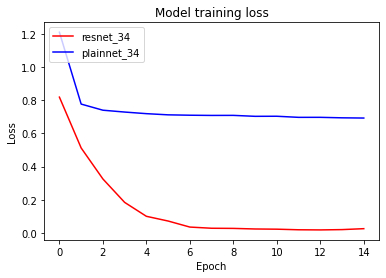

In [18]:
plt.plot(history_res_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plainnet_34'], loc='upper left')
plt.show()

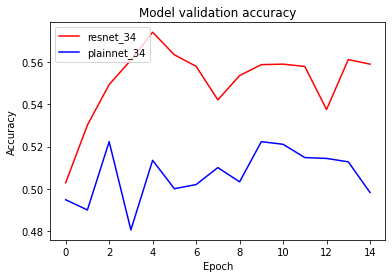

In [19]:
plt.plot(history_res_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plainnet_34'], loc='upper left')
plt.show()

In [20]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_res_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[20%:]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[0%:20%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
72/72 [==============================] - 53s 375ms/step - loss: 1.0144 - accuracy: 0.5152 - val_loss: 0.7553 - val_accuracy: 0.5023
Epoch 2/15
72/72 [==============================] - 27s 375ms/step - loss: 0.8745 - accuracy: 0.5339 - val_loss: 0.7576 - val_accuracy: 0.5000
Epoch 3/15
72/72 [==============================] - 27s 376ms/step - loss: 0.8279 - accuracy: 0.5423 - val_loss: 0.7381 - val_accuracy: 0.5261
Epoch 4/15
72/72 [==============================] - 29s 401ms/step - loss: 0.7991 - accuracy: 0.5455 - val_loss: 0.7639 - val_accuracy: 0.5278
Epoch 5/15
72/72 [==============================] - 28s 391ms/step - loss: 0.7763 - accuracy: 0.5549 - val_loss: 0.8024 - val_accuracy: 0.5124
Epoch 6/15
72/72 [==============================] - 26s 372ms/step - loss: 0.7640 - accuracy: 0.5581 - val_loss: 0.7735 - val_accuracy: 0.5304
Epoch 7/15
72/72 [==============================] - 26s 370ms/step - loss: 0.7346 - accuracy: 0.5785 - val_loss: 0.7867 - val_accuracy: 0.5330

In [24]:
plain_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[20%:]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[0%:20%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


72/72 [==============================] - 51s 372ms/step - loss: 1.1304 - accuracy: 0.4580 - val_loss: 1.3459 - val_accuracy: 0.5098
Epoch 2/15
72/72 [==============================] - 26s 364ms/step - loss: 0.7705 - accuracy: 0.5058 - val_loss: 0.9213 - val_accuracy: 0.5025
Epoch 3/15
72/72 [==============================] - 29s 407ms/step - loss: 0.7546 - accuracy: 0.4949 - val_loss: 0.8060 - val_accuracy: 0.4900
Epoch 4/15
72/72 [==============================] - 26s 371ms/step - loss: 0.7435 - accuracy: 0.5038 - val_loss: 0.7440 - val_accuracy: 0.5015
Epoch 5/15
72/72 [==============================] - 27s 382ms/step - loss: 0.7353 - accuracy: 0.4993 - val_loss: 0.7256 - val_accuracy: 0.4939
Epoch 6/15
72/72 [==============================] - 29s 402ms/step - loss: 0.7293 - accuracy: 0.5018 - val_loss: 0.7278 - val_accuracy: 0.4902
Epoch 7/15
72/72 [==============================] - 26s 362ms/step - loss: 0.7275 - accuracy: 0.4997 - val_loss: 0.7143 - val_accuracy: 0.5152
Epoch 8/15

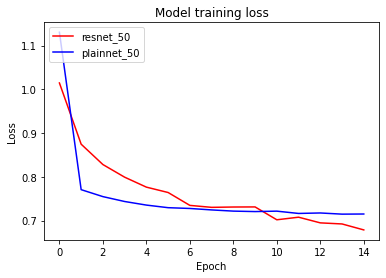

In [25]:
plt.plot(history_res_50.history['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plainnet_50'], loc='upper left')
plt.show()

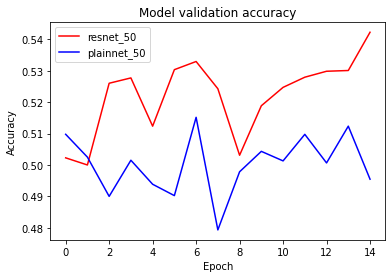

In [26]:
plt.plot(history_res_50.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plainnet_50'], loc='upper left')
plt.show()